In [1]:
import itertools

import numpy as np
import pandas as pd

from sklearnex import patch_sklearn
patch_sklearn()

import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GroupKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from statannotations.Annotator import Annotator

from gensim.models import Word2Vec

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

In [3]:
data_dir = '/s/project/mll/sergey/effect_prediction/MLM/griesemer/'

# Combine all info together

In [3]:
expression_df = pd.read_csv(data_dir + 'paper_supplementary/Variant_MPRAu_Results.txt', sep='\t')
oligo_info_df = pd.read_csv(data_dir + 'paper_supplementary/Oligo_Variant_Info.txt', sep='\t')

In [4]:
#Add seqeunces from FASTA file

fasta_fa = data_dir + 'fasta/GRCh38_UTR_variants.fa'

seq = {}

with open(fasta_fa, 'r') as f:
    for line in f:
        if line.startswith('>'):
            oligo_id = line[1:].replace(':Homo_sapiens\n','')
            seq[oligo_id] = ''
        else:
            seq[oligo_id] += line.rstrip()

mpra_df = pd.DataFrame(seq.items(), columns=['oligo_id', 'seq'])

In [5]:
utr_variants = pd.read_csv(data_dir + '/GRCh38_UTR_variants.tsv', sep='\t')

In [6]:
#distance between variant and stop codon, different calculations for positive and negative genes

utr_variants['stop_codon_dist'] = utr_variants.apply(lambda x: x.var_start-x.human_UTR_start if x.strand=='+' else
                  x.human_UTR_end - x.var_start, axis=1) 

In [7]:
#minimal free energy from RNAfold software, recalculate each time when FASTA file changes!

mpra_df['min_free_energy'] = pd.read_csv(data_dir + 
'fasta/GRCh38_UTR_variants.free_energy.tsv', header=None).squeeze() 

In [8]:
#combine all information together

mpra_df = mpra_df.merge(oligo_info_df[['oligo_id','mpra_variant_id','ref_allele','alt_allele', 'gene_symbols','chrom', 'oligo_starts', 'oligo_ends']]).merge(expression_df).merge(utr_variants[['mpra_variant_id','stop_codon_dist']].drop_duplicates())

mpra_df.columns

Index(['oligo_id', 'seq', 'min_free_energy', 'mpra_variant_id', 'ref_allele',
       'alt_allele', 'gene_symbols', 'chrom', 'oligo_starts', 'oligo_ends',
       'log2FoldChange_Skew_HEK293FT', 'lfcSE_Skew_HEK293FT',
       'pvalue_Skew_HEK293FT', 'padj_Skew_HEK293FT',
       'log2FoldChange_Ref_HEK293FT', 'lfcSE_Ref_HEK293FT',
       'pvalue_Ref_HEK293FT', 'padj_Ref_HEK293FT',
       'log2FoldChange_Alt_HEK293FT', 'lfcSE_Alt_HEK293FT',
       'pvalue_Alt_HEK293FT', 'padj_Alt_HEK293FT', 'log2FoldChange_Skew_HEPG2',
       'lfcSE_Skew_HEPG2', 'pvalue_Skew_HEPG2', 'padj_Skew_HEPG2',
       'log2FoldChange_Ref_HEPG2', 'lfcSE_Ref_HEPG2', 'pvalue_Ref_HEPG2',
       'padj_Ref_HEPG2', 'log2FoldChange_Alt_HEPG2', 'lfcSE_Alt_HEPG2',
       'pvalue_Alt_HEPG2', 'padj_Alt_HEPG2', 'log2FoldChange_Skew_HMEC',
       'lfcSE_Skew_HMEC', 'pvalue_Skew_HMEC', 'padj_Skew_HMEC',
       'log2FoldChange_Ref_HMEC', 'lfcSE_Ref_HMEC', 'pvalue_Ref_HMEC',
       'padj_Ref_HMEC', 'log2FoldChange_Alt_HMEC', 'lfcSE_A

In [9]:
# Define Groups for Group K-fold based on genes

mpra_df['group'] = mpra_df['gene_symbols']

In [10]:
#Very few 3'UTR regions are shared between genes
#The corresponding oligos should have the same group label

df = mpra_df.sort_values(by=['chrom','oligo_starts','oligo_ends']).drop_duplicates(subset=['mpra_variant_id']).reset_index(drop=True)

df['other_mpra_variant_id'] = ''

for row_idx in range(len(df)-1):
    next_row_idx = row_idx+1
    while df.loc[row_idx].chrom==df.loc[next_row_idx].chrom and df.loc[next_row_idx].oligo_starts<df.loc[row_idx].oligo_ends:
        if df.loc[row_idx].gene_symbols != df.loc[next_row_idx].gene_symbols:
            df.loc[row_idx,'other_mpra_variant_id'] += df.loc[next_row_idx,'mpra_variant_id'] + ','
        next_row_idx+=1
        
df = df.loc[df.other_mpra_variant_id!='',['mpra_variant_id','other_mpra_variant_id']]  

for mpra_variant_id, other_mpra_variant_ids in df.values.tolist():
    for other_mpra_variant_id in other_mpra_variant_ids.rstrip(',').split(','):
        mpra_df.loc[mpra_df.mpra_variant_id==other_mpra_variant_id,'group'] = mpra_df.loc[mpra_df.mpra_variant_id==mpra_variant_id,'group'].iloc[0]

In [11]:
#mpra_df.to_csv(data_dir + 'mpra_df.tsv', index=None, sep='\t')

# Utility functions

In [4]:
class Kmerizer:
    '''
    Helper class for k-mers and Word2Vec embeddings
    '''
    
    def __init__(self, k):
        
        self.k = k
        self.kmers = {"".join(x):i for i,x in zip(range(4**k), itertools.product("ACGT",repeat=k))} #generate all possible k-mers
        
    def kmerize(self, seq):
        '''
        Count all k-mers in the sequence 
        Returns:
        A list with counts corresponding to each possible k-mer from self.kmers
        e.g. for k=2 and seq='ACTAC'
        > [0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
        '''
        counts = [0]*4**self.k
        for i in range(len(seq) - self.k + 1): 
            kmer = seq[i:i+self.k]
            counts[self.kmers[kmer]] += 1
        return counts
    
    def tokenize(self, seq):
        '''
        Get all k-mers in the sequence
        Returns:
        A list of all k-mers
        e.g. for 2-mers and seq='ACTAC' 
        > ['AC', 'CT', 'TA', 'AC']
        '''
        kmers = []
        for i in range(len(seq) - self.k + 1): 
            kmer = seq[i:i+self.k]
            kmers.append(kmer)
        return kmers

In [5]:
def pearson_r(x,y):
    '''
    Compute Pearson r coefficient between samples x and y
    '''
    x = np.array(x)
    y = np.array(y)
    cov_xy = np.mean((x - x.mean()) * (y - y.mean()))
    r = cov_xy / (x.std() * y.std())
    return r

def pearson_r2_scorer(estimator, X, y):
    '''
    Scikit-learn compatible pearson scorer
    '''
    y_pred = estimator.predict(X).reshape(-1)
    #return scipy.stats.pearsonr(y, y_pred)[0] ** 2
    return pearson_r(y, y_pred)**2

In [6]:
def max_repeat_length(seq,k):
    
    '''
    Get repeat lengths of all k-mers in sequence
    Returns:
    Array of maximal repeat lengths for all k-mers
    '''

    max_subseq_length = {"".join(x):0 for x in itertools.product("ACGT",repeat=k)}

    for start in range(k):
        n_repeats=1 #each subsequence has at least 1 repeat
        for seq_idx in range(start,len(seq)-k+1,k):
            subseq = seq[seq_idx:seq_idx+k] #current subsequence
            if subseq==seq[seq_idx+k:seq_idx+2*k]: #if repeated at the next position
                n_repeats+=1 #increase repeats counter
            else:
                max_subseq_length[subseq] = max(max_subseq_length[subseq],n_repeats) #is the current subseq repeat longer?
                n_repeats = 1 #reinitialize repeats counter
                
        max_subseq_length[subseq] = max(max_subseq_length[subseq],n_repeats) #end of the sequence
       
    repeat_length = np.array(list(max_subseq_length.values()))
    
    return repeat_length

# Load data

In [6]:
mpra_df = pd.read_csv(data_dir + 'mpra_df.tsv', sep='\t') #sequence info

In [7]:
mlm_embeddings = np.load(data_dir + "embeddings/seq_len_5000/embeddings.npy") #masked language model embeddings

In [8]:
cell_type = 'HMEC' #HMEC,HEK293FT,HEPG2,K562,GM12878,SKNSH

In [9]:
#Data Cleaning
# Take only SNP mutations
# Remove nan values in Expression column

is_snp = mpra_df.ref_allele.str.len() == mpra_df.alt_allele.str.len()

flt = mpra_df[f'log2FoldChange_Skew_{cell_type}'].isna()  | (~is_snp) | (mpra_df.stop_codon_dist>5000) #| mpra_df.oligo_id.str.contains('_ref$')

mpra_df = mpra_df[~flt]

In [10]:
#predict Log2FC skew between Ref and Alt alleles or just treat ref and alt seqeunces equally

predict_skew = False 

In [11]:
if predict_skew:
    mpra_df['Expression'] = mpra_df[f'log2FoldChange_Skew_{cell_type}']
    mpra_df['seqtype'] = mpra_df.apply(lambda x: 'REF' if x.oligo_id.endswith('_ref') else 'ALT',axis=1)
    assert (mpra_df.loc[mpra_df.seqtype=='REF','mpra_variant_id'].values==\
         mpra_df.loc[mpra_df.seqtype=='ALT','mpra_variant_id'].values).mean()==1
else:
    mpra_df['Expression'] = mpra_df.apply(lambda x: x[f'log2FoldChange_Alt_{cell_type}'] if x.oligo_id.endswith('_alt') else x[f'log2FoldChange_Ref_{cell_type}'], axis=1)   

In [12]:
# Conver Expression column to float

mpra_df.Expression = mpra_df.Expression.apply(lambda x:x.replace(',','.') if type(x)==str else x).astype(float)

In [13]:
def minseq_model(mpra_df):
    
    '''
    Minimal sequence model from Griesemer et al. 2021
    
    Extracts following features from mpra_df:
    --nucleotide counts for each base (+4) and maximum among them (+1)
    --dinucleotide counts (+16) and maximum among them (+1)
    --maximum homopolymer length for all bases (+4)
    --maximum dinucleotide repeat length length for all bases (+16)
    --sequence uniformity (+1)
    --Minimal free energy (from RNA fold Software) (+1)
    
    Returns:
    Feature matrix X
    '''
    
    kmerizer1 = Kmerizer(k=1)

    nucl_counts = np.stack(mpra_df.seq.apply(lambda seq: kmerizer1.kmerize(seq)))
    max_nucl_counts_all = nucl_counts.max(axis=1)

    kmerizer2 = Kmerizer(k=2)

    dinucl_counts = np.stack(mpra_df.seq.apply(lambda seq: kmerizer2.kmerize(seq)))
    max_dinucl_counts_all = dinucl_counts.max(axis=1)
    
    max_homopol_len = np.stack(mpra_df.seq.apply(lambda seq: max_repeat_length(seq,1)))
    max_dinucl_len = np.stack(mpra_df.seq.apply(lambda seq: max_repeat_length(seq,2)))

    seq_uniformity = mpra_df.seq.apply(lambda seq: np.sum([seq[i]==seq[i-1] for i in range(1,len(seq))])).values
    min_free_energy = mpra_df['min_free_energy'].values
    
    X = np.hstack((nucl_counts,np.expand_dims(max_nucl_counts_all,axis=1),
           dinucl_counts,np.expand_dims(max_dinucl_counts_all,axis=1),
           max_homopol_len, max_dinucl_len,
           np.expand_dims(seq_uniformity,axis=1),
           np.expand_dims(min_free_energy,axis=1),
           ))
    
    return X

def word2vec_model(mpra_df):
    
    '''
    Word2Vec model
    
    '''
    
    kmerizer_w2v = Kmerizer(k=4)
    w2v_model = Word2Vec(sentences=mpra_df.seq.apply(lambda x: kmerizer_w2v.tokenize(x)), 
                         vector_size=128, window=5, min_count=1, workers=4, sg=1)

    word2vec_emb = mpra_df.seq.apply(
        lambda x: np.mean([w2v_model.wv[x]  for x in kmerizer_w2v.tokenize(x)],axis=0))

    X = np.stack(word2vec_emb,axis=0)
    
    return X

In [14]:
def get_embeddings(mpra_df):
    '''
    Compute embeddings using each model
    
    Returns:
    Dictionary of feature matrices, dependent variable, groups for K-fold validation
    '''

    X_emb = mlm_embeddings[mpra_df.index] #Masked Language Model, take only embeddings that were not filtered out

    kmerizer4 = Kmerizer(k=4)
    X_4mer = np.stack(mpra_df.seq.apply(lambda x: kmerizer4.kmerize(x))) #4-mer model

    X_minseq = minseq_model(mpra_df) #Griesemer minimal sequence model
    
    X_w2v = word2vec_model(mpra_df) #Word2Vec model
    
    min_free_energy = mpra_df['min_free_energy'].values
    
    #Only Griesemer model uses RNAfold minimal free energy ba default
    #we add this feature to the other models to provide fair comparison
    
    X_emb = np.hstack((X_emb,np.expand_dims(min_free_energy,axis=1)))
    X_4mer = np.hstack((X_4mer,np.expand_dims(min_free_energy,axis=1)))
    X_w2v = np.hstack((X_w2v,np.expand_dims(min_free_energy,axis=1)))

    data_matrices = {"MLM":X_emb,
                 "4-mer counts":X_4mer,
                 "Word2Vec": X_w2v,
                 "Griesemer et al.": X_minseq,
                }
    
    y = mpra_df['Expression'].values

    groups = mpra_df['group'].values
    
    return data_matrices, y, groups

In [15]:
if predict_skew:
    #Generate separate embeddings for Ref and Alt seqeunces and merge them
    data_matrices_ref, _, _ = get_embeddings(mpra_df[mpra_df.seqtype=='REF'])
    data_matrices_alt, y, groups = get_embeddings(mpra_df[mpra_df.seqtype=='ALT'])
    data_matrices = {model:np.hstack((data_matrices_ref[model],data_matrices_alt[model])) for model in data_matrices_ref}
else:
    data_matrices, y, groups = get_embeddings(mpra_df)

In [16]:
from torch import nn
from torch.optim import AdamW
import torch

class MLPRegressor():
    def __init__(self, hidden_layer_sizes=(64,32,16,), 
                 p_dropout=0, weight_decay=0, lr=0.0005,
                batch_size = 1000, N_epochs = 500, **kwargs):
                
        self.hidden_layer_sizes = hidden_layer_sizes
        self.p_dropout = p_dropout
        self.weight_decay = weight_decay
        self.lr = lr
        
        self.batch_size = batch_size
        self.N_epochs = N_epochs
        
        self.loss_fn = nn.MSELoss()

    def init_model(self):
        
        #define model architecture
        model_layers = []
        for layer_size in self.hidden_layer_sizes:
            model_layers.extend((nn.LazyLinear(layer_size), nn.Dropout(self.p_dropout), nn.ReLU(),))
        model_layers.append(nn.LazyLinear(1))
        self.model = nn.Sequential(*model_layers)
        
        #initialize optimizer
        self.optimizer = AdamW(self.model.parameters(), weight_decay=self.weight_decay, lr=self.lr)
    
    def scorer(self, y_true, y_pred):
        y_true = y_true.detach().numpy()[:,0]
        y_pred = y_pred.detach().numpy()[:,0]
        return pearson_r(y_true, y_pred) ** 2 
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
        if not X_val is None:
            X_val = torch.tensor(X_val, dtype=torch.float32)
            y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
        
        self.init_model()
        
        self.history = [] #history for train and validation metrics
        
        batches_per_epoch = int(np.ceil(len(X_train)//self.batch_size))
        
        self.model.train()
        
        for epoch in range(self.N_epochs):
            train_score, val_score = 0, 0
            for batch_idx in range(batches_per_epoch):
                # take a batch
                X_batch = X_train[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]
                y_batch = y_train[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]
                # forward pass
                y_pred = self.model(X_batch)
                loss = self.loss_fn(y_pred, y_batch)
                # backward pass
                self.optimizer.zero_grad()
                loss.backward()
                # update weights
                self.optimizer.step()
                train_score += self.scorer(y_batch, y_pred)/batches_per_epoch
            if not X_val is None:
                self.model.eval()
                y_pred = self.model(X_val)
                val_score = self.scorer(y_val, y_pred)
            self.history.append((train_score,val_score))
        
    def predict(self, X):
        
        self.model.eval()
        
        X = torch.tensor(X, dtype=torch.float32)
        
        y_pred = self.model(X)
        y_pred = y_pred.detach().numpy()[:,0]
        return y_pred
        
    def set_params(self, **kwargs):
        
        self.__dict__.update(kwargs)
        
    def score(self, X, y_true):
        
        X = torch.tensor(X, dtype=torch.float32)
        y_true = torch.tensor(y_true, dtype=torch.float32).reshape(-1, 1)
        
        y_pred = self.predict(X)
        return self.scorer(y_true,y_pred)
    
#M = MLPRegressor(p_dropout=0.1,weight_decay=1e-3,batch_size=1000)
#M.set_params(N_epochs=500)
#M.fit(X_train,y_train,X_test,y_test)

In [17]:
def group_cv(clf, parameter_grid, strategy='grid', n_splits = 10, random_state = 1):
    
    '''
    Group Cross-Validation
    If parameter_grid!=None, Use Hyperparameters found in the 0th fold
    
    Parameters:
    clf: Scikit-learn-compatible classifier
    parameter grid: dictionary of parameter values for hyperparameter search
    strategy: 'grid' for Grid Search or 'random' for Random Search
    
    Returns:
    Pearson r^2 coefficient for all folds
    '''

    group_kfold = GroupKFold(n_splits=n_splits)

    kfold_scores = []

    for fold_idx, (train_idx, test_idx) in enumerate(group_kfold.split(X, y, groups)):
        
        #print(f'FOLD {fold_idx}')
        
        X_train, y_train, groups_train = X[train_idx,:], y[train_idx], groups[train_idx]
        X_test, y_test = X[test_idx,:], y[test_idx]

        if fold_idx==0 and parameter_grid!=None:
            print('Performing hyperparameter search in FOLD 0')
            if strategy=='grid':
                gs = make_pipeline(StandardScaler(),
                                            GridSearchCV(clf, parameter_grid, cv=3))
                gs.fit(X_train, y_train, gridsearchcv__groups=groups_train)
                best_params = gs['gridsearchcv'].best_params_
            else:
                rs = make_pipeline(StandardScaler(),
                                            RandomizedSearchCV(clf, parameter_grid, cv=3, random_state=random_state))
                rs.fit(X_train, y_train, randomizedsearchcv__groups=groups_train)
                best_params = rs['randomizedsearchcv'].best_params_  
            print(f'Found best parameters: {best_params}')
        
        if parameter_grid!=None:
            clf.set_params(**best_params) #set parameters from the 0th fold
        
        #train 
        pipe = make_pipeline(StandardScaler(), clf)
        pipe.fit(X_train, y_train)
        
        #inference
        y_pred = pipe.predict(X_test)
        fold_score = pearson_r(y_pred,y_test)**2
        
        kfold_scores.append(fold_score)
        
    return kfold_scores

In [22]:
X = data_matrices['MLM']

In [ ]:
pipe = make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.RidgeCV(cv=3)) #limit runtime
#rmse = -cross_val_score(pipe,X,y,scoring="neg_root_mean_squared_error",cv=sklearn.model_selection.GroupKFold(n_splits=10), groups=groups)#.mean()
r2 = cross_val_score(pipe,X,y,scoring=pearson_r2,cv=sklearn.model_selection.GroupKFold(n_splits=10), groups=groups, n_jobs=-1)#.mean()


In [55]:
from sklearn.model_selection import GroupShuffleSplit


# Assessing model stability

For a stable model, the predictions are robust with respect to small changes in the train set.

To assess model stability, one performs repeated Cross-Validation: at each round the dataset is split into the same number of folds, but the fold contents is different. Then deviations in predictions for each test point are estimated.

Example for classification:

![Model stability](https://i.stack.imgur.com/vqyGM.png)

In [233]:
N_rounds = 100 #number of CV rounds
N_splits = 10 #number of CV splits in each round

pipe = make_pipeline(sklearn.preprocessing.StandardScaler(), 
                     sklearn.linear_model.RidgeCV(cv=3)) 

N_instances = len(y) #total number of test points equals to dataset size

cv_res = np.zeros((N_rounds*N_splits,N_instances)) #CV predictions for each point
cv_res[:] = np.NaN 

cv_scores = [] #Pearson R^2 for each fold in each round, N_rounds X N_splits

for round_idx in range(N_rounds):

    gss = GroupShuffleSplit(n_splits=N_splits, train_size=.9, random_state = round_idx) #10-fold CV

    for fold_idx, (train_idx, test_idx) in enumerate(gss.split(X, y, groups)):
       
        X_train, X_test, y_train, y_test = X[train_idx,:],X[test_idx,:],y[train_idx],y[test_idx]
        
        pipe.fit(X_train,y_train)
        
        y_pred = pipe.predict(X_test)
            
        cv_res[round_idx*N_splits+fold_idx,test_idx] = y_pred #predictions for test instances in this fold in this round
        
        cv_scores.append((pearson_r(y_pred,y_test)**2, round_idx)) #score for this fold in this round
        
cv_scores = pd.DataFrame(cv_scores, columns=['Pearson r^2', 'CV round'])

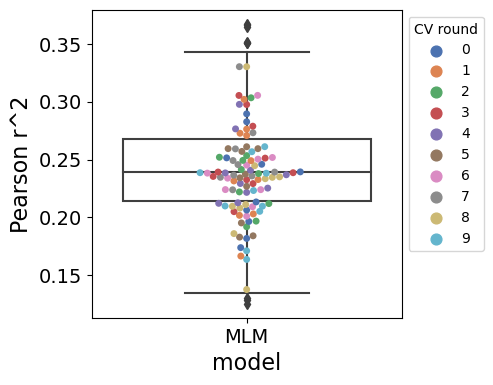

In [242]:
fig, ax = plt.subplots(figsize=(4,4))

cv_scores['model'] = 'MLM'

ax = sns.swarmplot(data=cv_scores[cv_scores['CV round']<10],y='Pearson r^2',x='model',hue="CV round", palette="deep")
ax = sns.boxplot(data=cv_scores,y='Pearson r^2',x='model', boxprops={'facecolor':'None'})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [255]:
y_pred_av = np.nanmean(cv_res,axis=0) #average prediction for each point (not necessarily correct)

mae = np.nanmean(np.absolute(cv_res - y_pred_av)) #mean absolute error for each point across rounds

mae_relative = np.absolute(mae/y_pred_av) #relative MAE w.r.t. average prediction

In [260]:
for pct in (25, 50, 75, 90):
    percentile = np.percentile(mae_relative, pct)
    print(f'{pct}% of points deviate by less than {round(percentile*100):2d}% due to train set change')

25% of points deviate by less than  5% due to train set change
50% of points deviate by less than  9% due to train set change
75% of points deviate by less than 19% due to train set change
90% of points deviate by less than 49% due to train set change


The model is quite unstable: mild variations in the train set lead to considerabel variations in predicted value for each test instance.
When choosing models, we prefer stable ones.

How to fight instability?

- add regularization
- use stable algorithms
- perform feature engineering

How to estimate generalization performance of an unstable model?

In [234]:
score_per_round = cv_scores.groupby('CV round')['Pearson r^2'].mean()

CV_rounds = np.arange(1,N_rounds+1)

average_score = np.cumsum(score_per_round)/CV_rounds

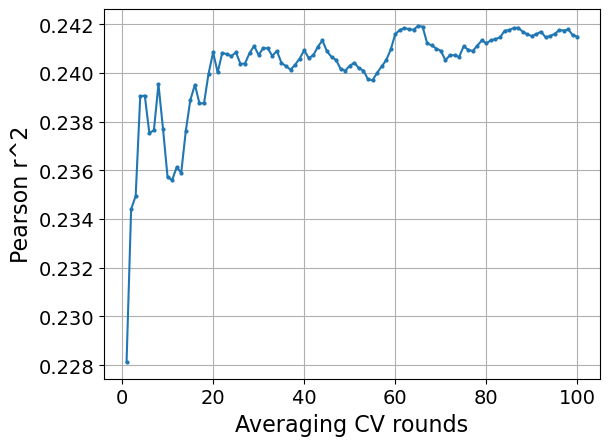

In [261]:
fig, ax = plt.subplots()

ax.plot(CV_rounds, average_score, marker='o', markersize=2)
ax.set_xlabel('Averaging CV rounds')
ax.set_ylabel('Pearson r^2')
ax.grid()

In [61]:
mp=np.nanmean(y_pred,axis=0)

In [73]:
M = MLPRegressor(p_dropout=0.1,weight_decay=2)
M.fit(X_train,y_train,X_test,y_test)


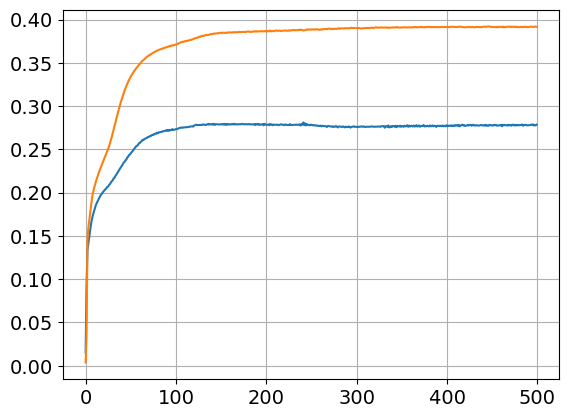

In [74]:
t,v = zip(*M.history)
fig, ax = plt.subplots()
ax.plot(v)
ax.plot(t)
ax.grid()

In [75]:
metrics_mpra = []

clf = sklearn.linear_model.Ridge()
parameter_grid = {'alpha':10.**np.arange(-10,10)}
        
#clf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000,n_jobs=-1,min_samples_leaf=25)
#parameter_grid = None

        
clf = MLPRegressor(p_dropout=0.1,weight_decay=2)
parameter_grid = None


clf = sklearn.linear_model.Ridge()
parameter_grid = {'alpha':10.**np.arange(-10,10)}
              
clf = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(64,32,16,), alpha=2, batch_size=1000, learning_rate='constant', 
                 learning_rate_init=5e-4, max_iter=500, shuffle=False, random_state=None)
parameter_grid = None


clf = sklearn.svm.SVR(C=4, epsilon=0.1)
parameter_grid = None#{'C':2.**np.arange(-5,5),'epsilon':10.**np.arange(-5,1)}

for model, X in data_matrices.items():
    
    print(model)
  
    r2 = group_cv(clf,parameter_grid,strategy='grid')
    
    for r2_val in r2:
        metrics_mpra.append((model, r2_val))

metrics_mpra = pd.DataFrame(metrics_mpra, columns=['model','score'])

MLM


/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga

4-mer counts


/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga

Word2Vec


/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga

Griesemer et al.


/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-spade/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data/ouga

In [76]:
metrics_mpra.groupby('model').mean()

,score
model,
4-mer counts,0.210851
Griesemer et al.,0.262618
MLM,0.311119
Word2Vec,0.243512


In [198]:
mpl.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 
                     'axes.titlesize':14, 'axes.labelsize':16})

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MLM vs. 4-mer counts: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
MLM vs. Word2Vec: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
MLM vs. Griesemer et al.: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:9.766e-03 Stat=3.000e+00


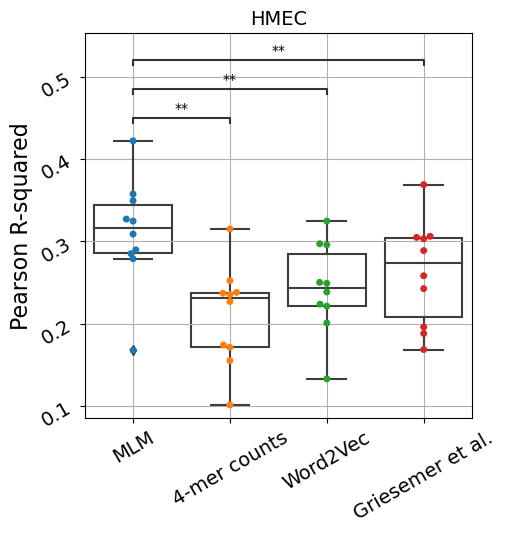

In [78]:
box_pairs=[
    ("MLM", "4-mer counts"),
    ("MLM", "Word2Vec"),
    ("MLM", "Griesemer et al."),
    ]

fig, ax = plt.subplots(figsize=(5,5), dpi=100)

ax = sns.swarmplot(data=metrics_mpra, x="model", y="score") #scatter plot
ax = sns.boxplot(data=metrics_mpra, x="model", y="score", boxprops={'facecolor':'None'})

annotator = Annotator(ax, box_pairs, data=metrics_mpra, x="model", y="score")
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
#annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="BH")

annotator.apply_and_annotate()

ax.set_xlabel("")
ax.set_ylabel("Pearson R-squared")
ax.tick_params(rotation=30)
ax.set_title(cell_type)
ax.grid()

#fig.savefig("../../../../Plots/Downstream_mpra.svg") 